<img src="https://futurejobs.my/wp-content/uploads/2021/05/d-min-1024x297.png" width="300"> </img>

> **Copyright &copy; 2021 Skymind Education Group Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0** 

# Object Detection

## Introduction

Object segmentation is the process of finding the boundaries of target objects in images. There are many applications for segmenting objects in an image. For example, by outlining anatomical objects in medical images, clinical experts can learn useful information about patient's conditions. The goal of automatic single-object segmentation is to predict a binary mask given in an image, whereby the object of interest will be in white and the background is black. 

<img src=""></img>

This hands-on will guide you through building a pipeline to automatically segment fetal head in ultrasound images, from scratch.

_Authored by: [Scotrraaj Gopal](http://github.com/scotgopal)_

In [1]:
from torchvision import datasets
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from pathlib import Path

In [2]:
DATASET_BASE_PATH = Path("../datasets").resolve()
VOC_DATASET_DIR = Path.joinpath(DATASET_BASE_PATH, "VOCdevkit")
if VOC_DATASET_DIR.exists():
    trainval_ds = datasets.VOCDetection(root="../datasets", image_set="trainval")
else:
    trainval_ds = datasets.VOCDetection(root="../datasets", image_set="trainval", download=True)

trainval_ds

Dataset VOCDetection
    Number of datapoints: 11540
    Root location: ../datasets

(217, 161) (294, 221)
(465, 167) (500, 218)


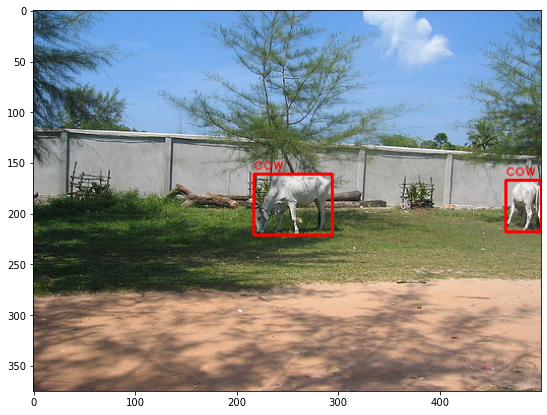

In [3]:
feature_image, target_annotation = trainval_ds[4]
for annotated_object in target_annotation['annotation']['object']:
    name = annotated_object['name']
    xmin = annotated_object['bndbox']['xmin']
    ymin = annotated_object['bndbox']['ymin']
    xmax = annotated_object['bndbox']['xmax']
    ymax = annotated_object['bndbox']['ymax']

    upper_left_point = (int(xmin), int(ymin))
    lower_right_point = (int(xmax), int(ymax))
    print(upper_left_point, lower_right_point)
    colour = (255,0,0)
    line_thickness = 2

    org = (int(xmin), int(ymin)-5)
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_colour = (255,0,0)
    

    feature_image = cv.rectangle(np.array(feature_image), upper_left_point, lower_right_point, colour, line_thickness)
    feature_image = cv.putText(img=feature_image, text=name, org=org, fontFace=font, fontScale=font_scale,color=font_colour, lineType=cv.LINE_AA, bottomLeftOrigin=False)

plt.figure(figsize=(19,7))
plt.imshow(feature_image)

In [5]:
import torchvision
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)

C:\Users\Scotrraaj.Gopal\miniconda3\envs\conda-pytorch3.9\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to C:\Users\Scotrraaj.Gopal/.cache\torch\hub\checkpoints\ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:25<00:00, 5.58MB/s] 


In [10]:
model.eval()
model.training

False

In [11]:
from sklearn.model_selection import ShuffleSplit
from torch.utils.data import Subset

shuffle_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indice_range = range(len(trainval_ds))
train_indices, val_indices = next(shuffle_split.split(indice_range))

voc_train_ds = Subset(trainval_ds, train_indices)
voc_val_ds = Subset(trainval_ds, val_indices)

In [14]:
voc_train_ds[0]

(<PIL.Image.Image image mode=RGB size=500x333 at 0x2C242F462E0>,
 {'annotation': {'filename': '2010_000716.jpg',
   'folder': 'VOC2012',
   'object': [{'name': 'dog',
     'bndbox': {'xmax': '329', 'xmin': '15', 'ymax': '236', 'ymin': '9'},
     'difficult': '0',
     'occluded': '0',
     'pose': 'Unspecified',
     'truncated': '1'}],
   'segmented': '0',
   'size': {'depth': '3', 'height': '333', 'width': '500'},
   'source': {'annotation': 'PASCAL VOC2010',
    'database': 'The VOC2010 Database',
    'image': 'flickr'}}})

In [ ]:

transform_val = 